**Experiment 10 : Solving a Markov
Decision Process (MDP)**

Name : Amishi Gupta

Roll No. 23/CS/048

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
GRID_ROWS = 3
GRID_COLS = 4
WALL = (1, 1)
GOAL = (0, 3)
PIT = (1, 3)
TERMINAL_STATES = [GOAL, PIT]

#Define MDP Parameters
GAMMA = 0.99  #Discount factor
THETA = 0.0001 #Convergence threshold
ACTIONS = ['up', 'down', 'left', 'right']

SLIP_ACTIONS = {
    'up': ['left', 'right'],
    'down': ['right', 'left'],
    'left': ['down', 'up'],
    'right': ['up', 'down']
}

#Define States
all_states = []
for r in range(GRID_ROWS):
    for c in range(GRID_COLS):
        if (r, c) != WALL:
            all_states.append((r, c))

print(f"Valid states: {all_states}")

#Define Rewards
def create_reward_function(living_penalty=-0.04):
    R = {}
    for s in all_states:
        if s == GOAL:
            R[s] = 1.0
        elif s == PIT:
            R[s] = -1.0
        else:
            R[s] = living_penalty
    return R

#Define Transition Model

def calculate_move(s, a):
    r, c = s

    #Calculate new position based on action
    if a == 'up':
        r_new = r - 1
        c_new = c
    elif a == 'down':
        r_new = r + 1
        c_new = c
    elif a == 'left':
        r_new = r
        c_new = c - 1
    elif a == 'right':
        r_new = r
        c_new = c + 1
    else:
        return s

    s_new = (r_new, c_new)

    if (
        r_new < 0 or r_new >= GRID_ROWS or
        c_new < 0 or c_new >= GRID_COLS or
        s_new == WALL
    ):
        return s
    else:
        return s_new

def get_next_states(s, a):
    if s in TERMINAL_STATES:
        return []

    intended_action = a
    slip_left = SLIP_ACTIONS[a][0]
    slip_right = SLIP_ACTIONS[a][1]

    s_intended = calculate_move(s, intended_action)
    s_slip_left = calculate_move(s, slip_left)
    s_slip_right = calculate_move(s, slip_right)
    next_states_prob = {}

    next_states_prob[s_intended] = next_states_prob.get(s_intended, 0.0) + 0.8
    next_states_prob[s_slip_left] = next_states_prob.get(s_slip_left, 0.0) + 0.1
    next_states_prob[s_slip_right] = next_states_prob.get(s_slip_right, 0.0) + 0.1
    return [(prob, state) for state, prob in next_states_prob.items()]

#Test the Transition Model
print("\nTransition Model Tests")
print(f"T((0,0), 'right'): {get_next_states((0,0), 'right')}")
print(f"T((1,2), 'up'): {get_next_states((1,2), 'up')}")

Valid states: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]

Transition Model Tests
T((0,0), 'right'): [(0.8, (0, 1)), (0.1, (0, 0)), (0.1, (1, 0))]
T((1,2), 'up'): [(0.8, (0, 2)), (0.1, (1, 2)), (0.1, (1, 3))]


In [7]:
def value_iteration(R):
    #Initialize Value Function
    V = {s: 0.0 for s in all_states}

    iteration = 0
    while True:
        iteration += 1
        delta = 0
        V_new = V.copy()

        #Loop through all states
        for s in all_states:

            if s in TERMINAL_STATES:
                V_new[s] = 0.0
                continue
            q_values = []

            #Loop through all possible actions
            for a in ACTIONS:
                q_s_a = 0.0

                for (prob, next_s) in get_next_states(s, a):
                    reward = R[next_s]
                    q_s_a += prob * (reward + GAMMA * V[next_s])

                q_values.append(q_s_a)
            V_new[s] = max(q_values)

            #Check for convergence
            delta = max(delta, abs(V_new[s] - V[s]))
        V = V_new

        if delta < THETA:
            break

    print(f"Value Iteration converged in {iteration} iterations.")
    return V

In [8]:
def extract_policy(V, R):
    Pi = {}

    for s in all_states:
        if s == GOAL:
            Pi[s] = 'GOAL'
            continue
        if s == PIT:
            Pi[s] = 'PIT'
            continue

        best_q = -np.inf
        best_a = ''
        for a in ACTIONS:
            q_s_a = 0.0
            for (prob, next_s) in get_next_states(s, a):
                reward = R[next_s]
                q_s_a += prob * (reward + GAMMA * V[next_s])

            if q_s_a > best_q:
                best_q = q_s_a
                best_a = a
        Pi[s] = best_a

    return Pi


Analysis 1: R(s) = -0.04
Value Iteration converged in 20 iterations.


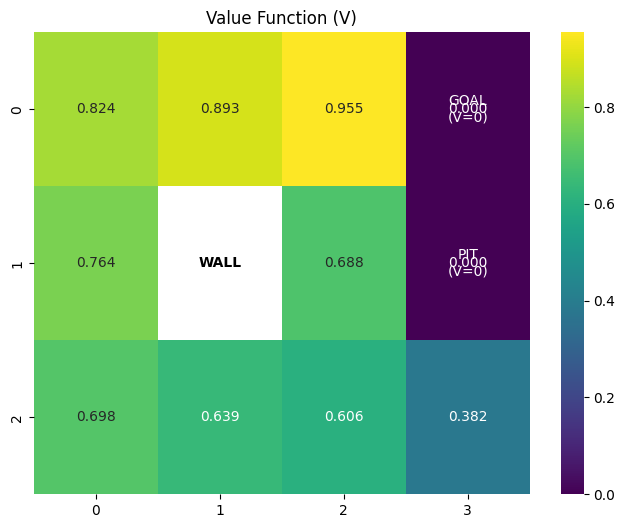

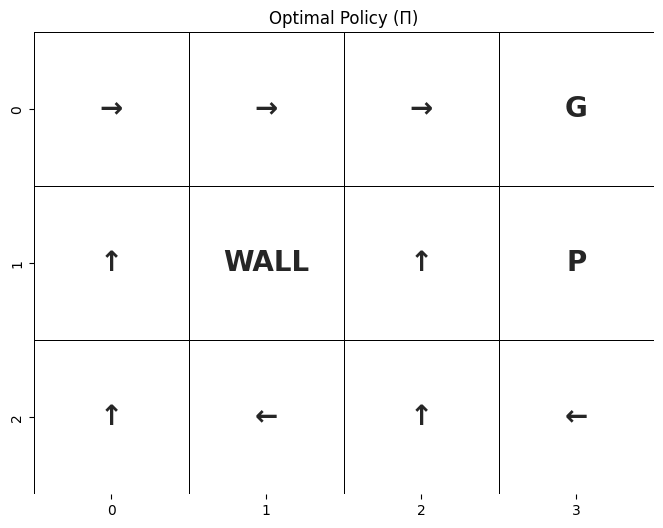


Analysis 2: R(s) = 0.0
Value Iteration converged in 65 iterations.


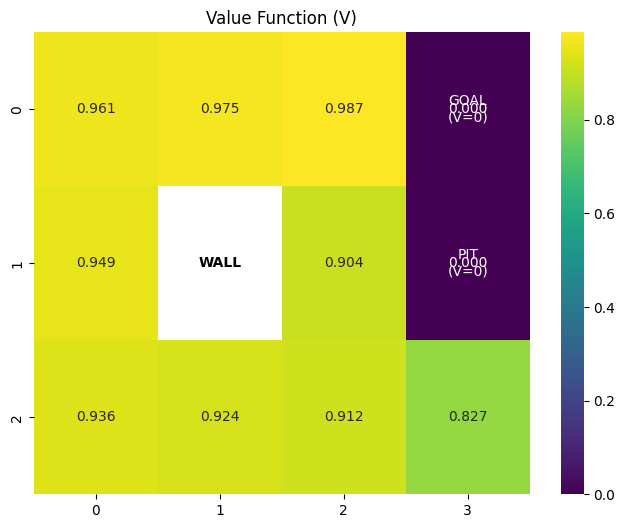

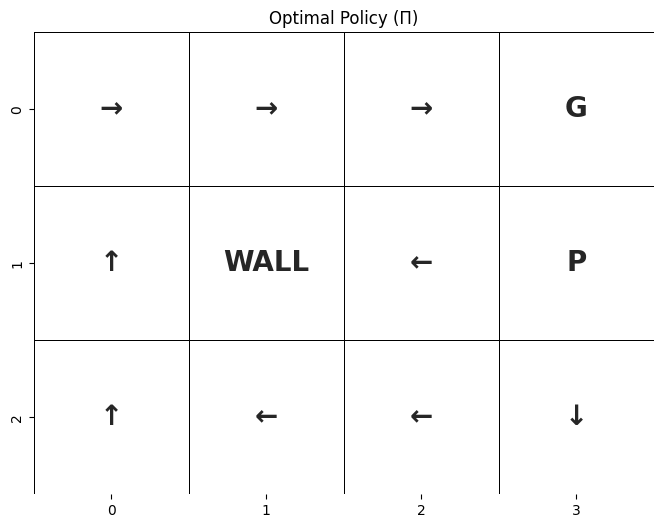


Analysis 3: R(s) = -0.5
Value Iteration converged in 17 iterations.


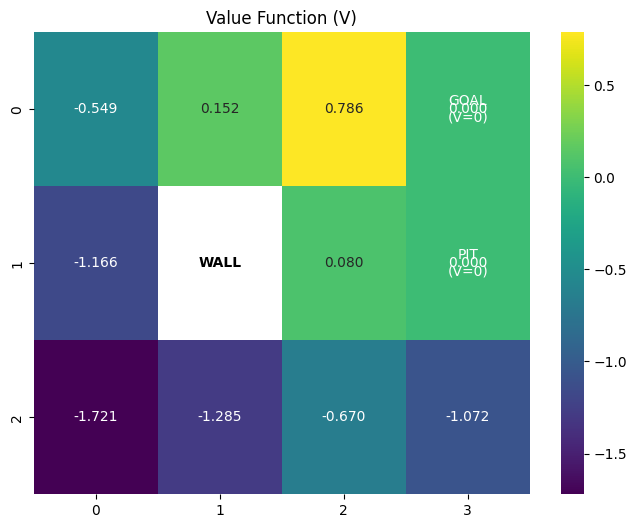

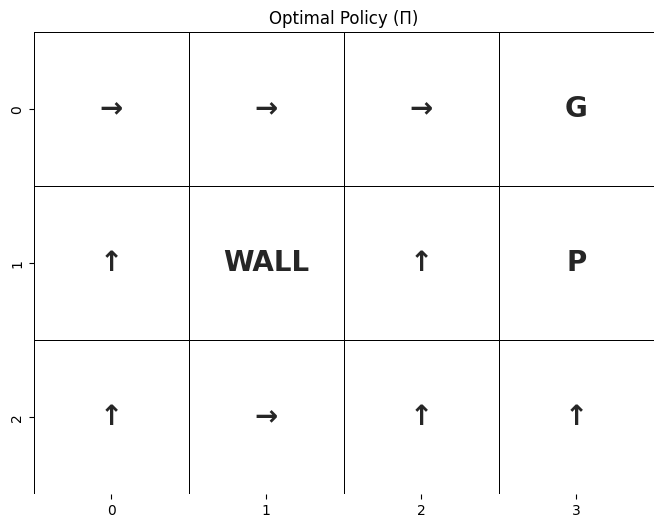

In [9]:
#Visualization Helper Functions

def visualize_v(V):
    v_grid = np.full((GRID_ROWS, GRID_COLS), np.nan)
    for s, v in V.items():
        r, c = s
        v_grid[r, c] = v
    mask = np.isnan(v_grid)

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(v_grid, annot=True, fmt=".3f", cmap="viridis", cbar=True, mask=mask)

    if not np.isnan(v_grid[WALL]): v_grid[WALL] = 0
    if not np.isnan(v_grid[GOAL]): v_grid[GOAL] = 0
    if not np.isnan(v_grid[PIT]): v_grid[PIT] = 0

    ax.text(WALL[1] + 0.5, WALL[0] + 0.5, "WALL", ha='center', va='center', color='black', weight='bold')
    ax.text(GOAL[1] + 0.5, GOAL[0] + 0.5, "GOAL\n(V=0)", ha='center', va='center', color='white')
    ax.text(PIT[1] + 0.5, PIT[0] + 0.5, "PIT\n(V=0)", ha='center', va='center', color='white')

    plt.title("Value Function (V)")
    plt.show()

def visualize_pi(Pi):
    arrow_map = {
        'up': '↑',
        'down': '↓',
        'left': '←',
        'right': '→',
        'GOAL': 'G',
        'PIT': 'P'
    }

    pi_grid = np.full((GRID_ROWS, GRID_COLS), "", dtype=object)

    for s, a in Pi.items():
        r, c = s
        pi_grid[r, c] = arrow_map.get(a, '?')

    pi_grid[WALL] = "WALL"

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(np.zeros((GRID_ROWS, GRID_COLS)), annot=pi_grid,
                     fmt="", cbar=False, cmap=['white'],
                     linewidths=0.5, linecolor='black',
                     annot_kws={"size": 20, "weight": "bold"})

    ax.set_title("Optimal Policy (Π)")
    plt.show()

#Analysis Questions

#Question 1: Run with default living penalty R(s) = -0.04
print("\nAnalysis 1: R(s) = -0.04")
R_default = create_reward_function(living_penalty=-0.04)
V_default = value_iteration(R_default)
Pi_default = extract_policy(V_default, R_default)

visualize_v(V_default)
visualize_pi(Pi_default)

#Question 2: Run with living penalty R(s) = 0.0
print("\nAnalysis 2: R(s) = 0.0")
R_zero = create_reward_function(living_penalty=0.0)
V_zero = value_iteration(R_zero)
Pi_zero = extract_policy(V_zero, R_zero)

visualize_v(V_zero)
visualize_pi(Pi_zero)

#Question 3: Run with high living penalty R(s) = -0.5
print("\nAnalysis 3: R(s) = -0.5")
R_high = create_reward_function(living_penalty=-0.5)
V_high = value_iteration(R_high)
Pi_high = extract_policy(V_high, R_high)

visualize_v(V_high)
visualize_pi(Pi_high)